# Part 1: Training a Convolutional Neural Network with LSTM

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from glob import glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential
from utils import * 

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False

2022-11-15 20:41:58.637286: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
cwd = os.getcwd()

train_path = os.path.join(cwd,'Data','train_val')
test_path  = os.path.join(cwd,'Data','test')

In [3]:
input_train = xr.open_dataset(os.path.join(train_path,'forcing_train.nc'))
input_test = xr.open_dataset(os.path.join(test_path,'forcing_test.nc'))

In [4]:
output_train = xr.open_dataset(os.path.join(train_path,'member_165_train.nc'))
output_test = xr.open_dataset(os.path.join(test_path,'member_165_test.nc'))

In [5]:
X_train_df = pd.DataFrame({"delta_T": input_train.delta_T.data},index=input_train.delta_T.coords['time'].data)

In [13]:
y_train_np = output_train.velsurf_mag.fillna(0).data

In [14]:
X_train_np = X_train_df.to_numpy()

In [16]:
print(X_train_np.shape,y_train_np.shape)

(1049, 1) (1049, 381, 381)


In [17]:
X_length = np.array([len(X_train)])

In [20]:
start = np.cumsum(X_length) - X_length
end   = np.cumsum(X_length)

slider = 5
n_samples   = X_train_np.shape[0] - (slider-1)*len(X_length)
n_lat,n_lon,n_feature = 1,1,1

X_train = np.zeros([n_samples,slider,n_lat,n_lon,n_feature])
y_train = np.zeros([n_samples,1,n_lat,n_lon])

n_start = 0
for i in range(len(X_length)):
    
    X_subset = X_train_np[start[i]:end[i],:]
    y_subset = y_train_np[start[i]:end[i],:]
    
    X_subset = np.array([X_subset[i:i+slider] for i in range(0, X_length[i]-slider+1)])
    y_subset = np.array([[y_subset[i+slider-1]] for i in range(0, X_length[i]-slider+1)])
    
    # print(X_subset.shape,y_subset.shape)
    n_length = X_subset.shape[0]
    X_train[n_start:n_start+n_length,:,:,:,:] = X_subset
    y_train[n_start:n_start+n_length,:,:,:]   = y_subset
    n_start += n_length
    
X_test  = np.array([X_test_np[i:i+slider] for i in range(0, X_test_np.shape[0]-slider+1)])


ValueError: could not broadcast input array from shape (1045,5,1) into shape (1045,5,1,1,1)

In [9]:
from tensorflow.keras import backend as K

def custom_rmse(y_true, y_pred):
    """
    custom_rmse(y_true, y_pred)
    calculates root square mean value with focusing only on the ocean
    """
    y_pred = y_pred[(y_true != 0) & (y_true != 0.0)]
    y_true = y_true[(y_true != 0) & (y_true != 0.0)]
    
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)

    return K.sqrt(K.mean(tf.math.squared_difference(y_pred, y_true),axis= -1))

In [32]:
n_filters  = 9  # number of filters
n_neurons  = 32  # number of neurons in the Dense layer
activation     = 'relu' # activation function
kernel_size    = 3
learning_rate  = 0.01
minibatch_size = 64
num_epochs     = 100

In [33]:
model = Sequential()

model.add(Dense(n_filters*127*127, input_shape=(X_train.shape[1],), activation=activation)) # shape: (6912,1)
model.add(Reshape((127,127,n_filters))) # shape: (12,18,32)

# Upsample to 96x144
model.add(Conv2DTranspose(filters=n_filters, kernel_size=kernel_size, 
                          activation=activation, strides=3, padding='same')) # shape: (96,144,32)

model.add(Conv2DTranspose(filters=1, kernel_size=kernel_size, activation="linear", padding="same")) # shape: (96,144,1)


model.compile(loss=custom_rmse,optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

In [34]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 145161)            290322    
                                                                 
 reshape_3 (Reshape)         (None, 127, 127, 9)       0         
                                                                 
 conv2d_transpose_6 (Conv2DT  (None, 381, 381, 9)      738       
 ranspose)                                                       
                                                                 
 conv2d_transpose_7 (Conv2DT  (None, 381, 381, 1)      82        
 ranspose)                                                       
                                                                 
Total params: 291,142
Trainable params: 291,142
Non-trainable params: 0
_________________________________________________________________


In [35]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)


history = model.fit(X_train, y_train, 
                    batch_size      = minibatch_size,
                    epochs          = num_epochs,
                    validation_split= 0.2, 
                    verbose         = 1,
                    callbacks       = [early_stop])



Epoch 1/100
14/14 [==============================] - 6s 127ms/step - loss: 185.4384 - val_loss: 120.2633
Epoch 2/100
14/14 [==============================] - 1s 61ms/step - loss: 177.1191 - val_loss: 102.4302
Epoch 3/100
14/14 [==============================] - 1s 61ms/step - loss: 157.1415 - val_loss: 120.3691
Epoch 4/100
14/14 [==============================] - 1s 61ms/step - loss: 142.3318 - val_loss: 107.8557
Epoch 5/100
14/14 [==============================] - 1s 60ms/step - loss: 132.6863 - val_loss: 113.3520
Epoch 6/100
14/14 [==============================] - 1s 61ms/step - loss: 126.1626 - val_loss: 107.7360
Epoch 7/100
14/14 [==============================] - 1s 61ms/step - loss: 120.4967 - val_loss: 105.4339
Epoch 8/100
14/14 [==============================] - 1s 62ms/step - loss: 115.3223 - val_loss: 100.9113
Epoch 9/100
14/14 [==============================] - 1s 61ms/step - loss: 110.4631 - val_loss: 96.7845
Epoch 10/100
14/14 [==============================] - 1s 61ms/st

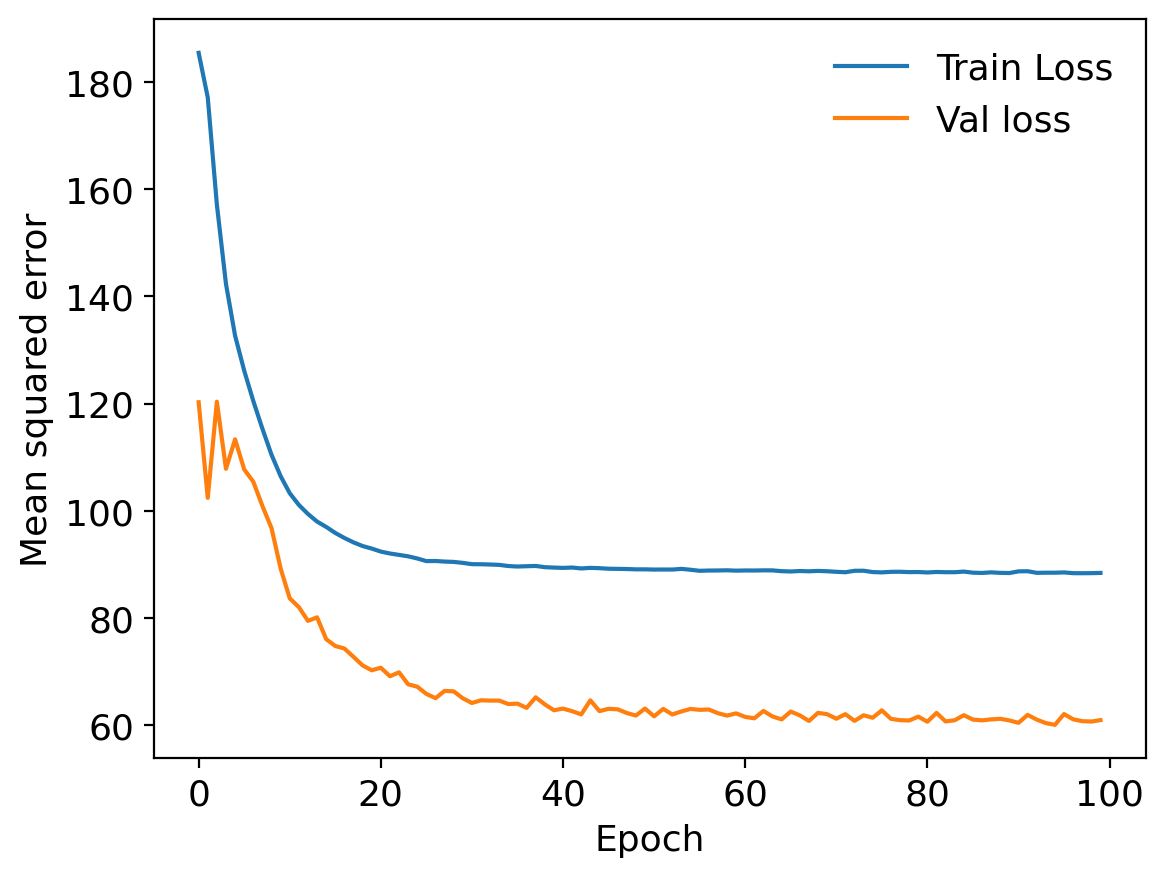

In [36]:
plot_history(history)

In [37]:
model_path = os.path.join(cwd,'saved_model')
make_dir(model_path)

In [38]:
model.save(os.path.join(model_path,'CNN_model_1_member.h5'))

## Testing

In [39]:
model = load_model(os.path.join(model_path,'CNN_model_1_member.h5'),custom_objects={'custom_rmse':custom_rmse})

In [40]:
X_test_df = pd.DataFrame({"delta_T": input_test.delta_T.data},index=input_test.delta_T.coords['time'].data)

In [41]:
y_test_df = output_test.velsurf_mag.fillna(0)

In [42]:
X_test = X_test_df.to_numpy()


In [43]:
y_test_pre = model.predict(X_test)


7/7 [==============================] - 1s 24ms/step


In [52]:
y_test_pre_rs = y_test_pre.reshape(y_test_df.shape[0],y_test_df.shape[1],y_test_df.shape[2])

y_test_pre_xr = xr.Dataset(coords={'time': X_test_df.index.values, 
                               'x': y_test_df.x.values, 
                               'y': y_test_df.y.values},
                       data_vars=dict(velsurf_mag=(['time', 'y', 'x'], y_test_pre_rs)))

In [53]:
y_test_pre_xr

<xarray.Dataset>
Dimensions:      (time: 200, y: 381, x: 381)
Coordinates:
  * time         (time) float64 -1.98e+04 -1.97e+04 -1.96e+04 ... 0.0 50.0
  * x            (x) float64 -3.04e+06 -3.024e+06 ... 3.024e+06 3.04e+06
  * y            (y) float64 -3.04e+06 -3.024e+06 ... 3.024e+06 3.04e+06
Data variables:
    velsurf_mag  (time, y, x) float32 7.673 8.384 7.874 ... 3.309 3.306 2.302

In [54]:
y_true =  y_test_df

In [55]:
y_true

<xarray.DataArray 'velsurf_mag' (time: 200, y: 381, x: 381)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
...
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)
Coordinates:
  * time     (time) float64 -1.98e+04 -1.97e+04 -1.96e+04 ... -100.0 0.0 50.0
  * x        (x) float64 -3.04e+06 -3.024e+06 -3.008e+06 ... 3.024e+06 3.04e+06
  * y        (y) float64 -3.04e+06 -3.024e+06 -3.008e+06 ... 3.024e+06 3.04e+06
Attributes:
    long_name:    magnitude of horizontal velocity of ice at ice surface
    units:        m year-1
    pism_intent:  diagnostic

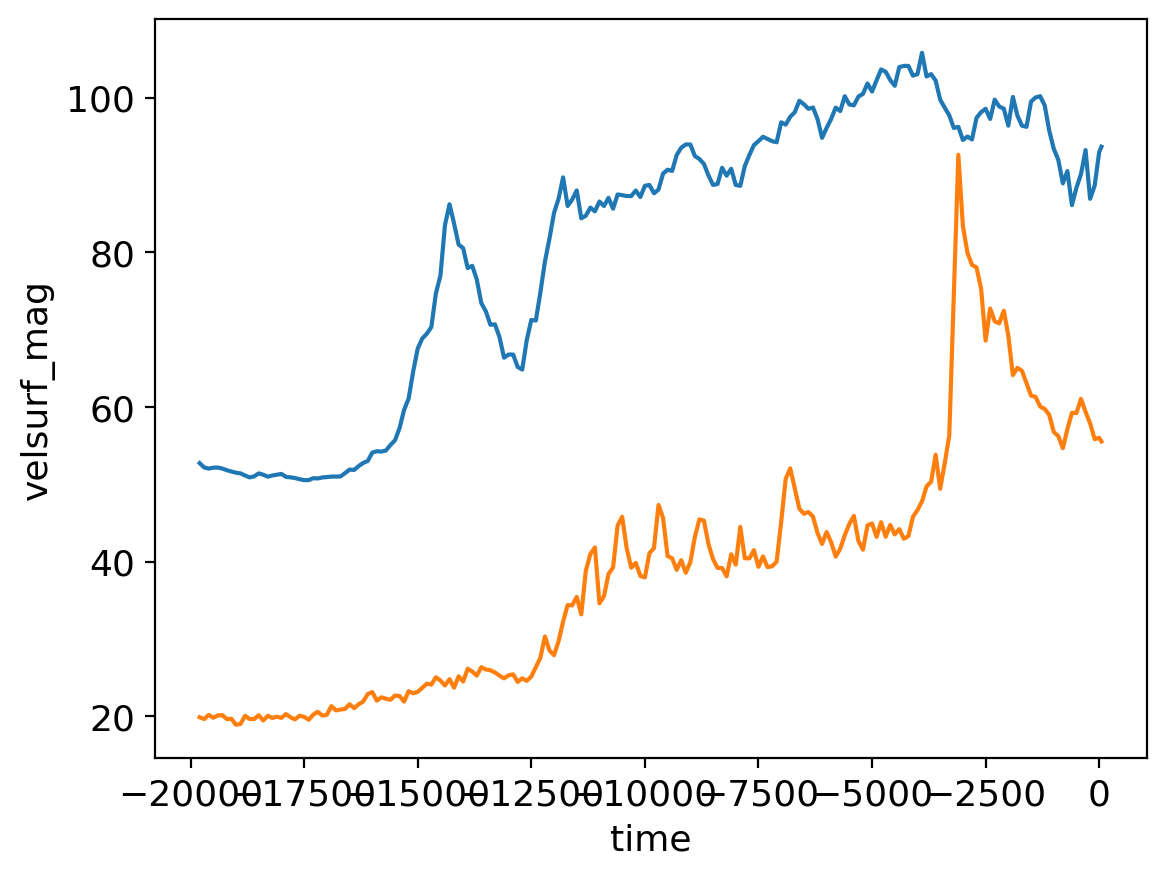

In [56]:
y_test_pre_xr.velsurf_mag.mean(dim=['x','y']).plot()
y_true.mean(dim=['x','y']).plot()

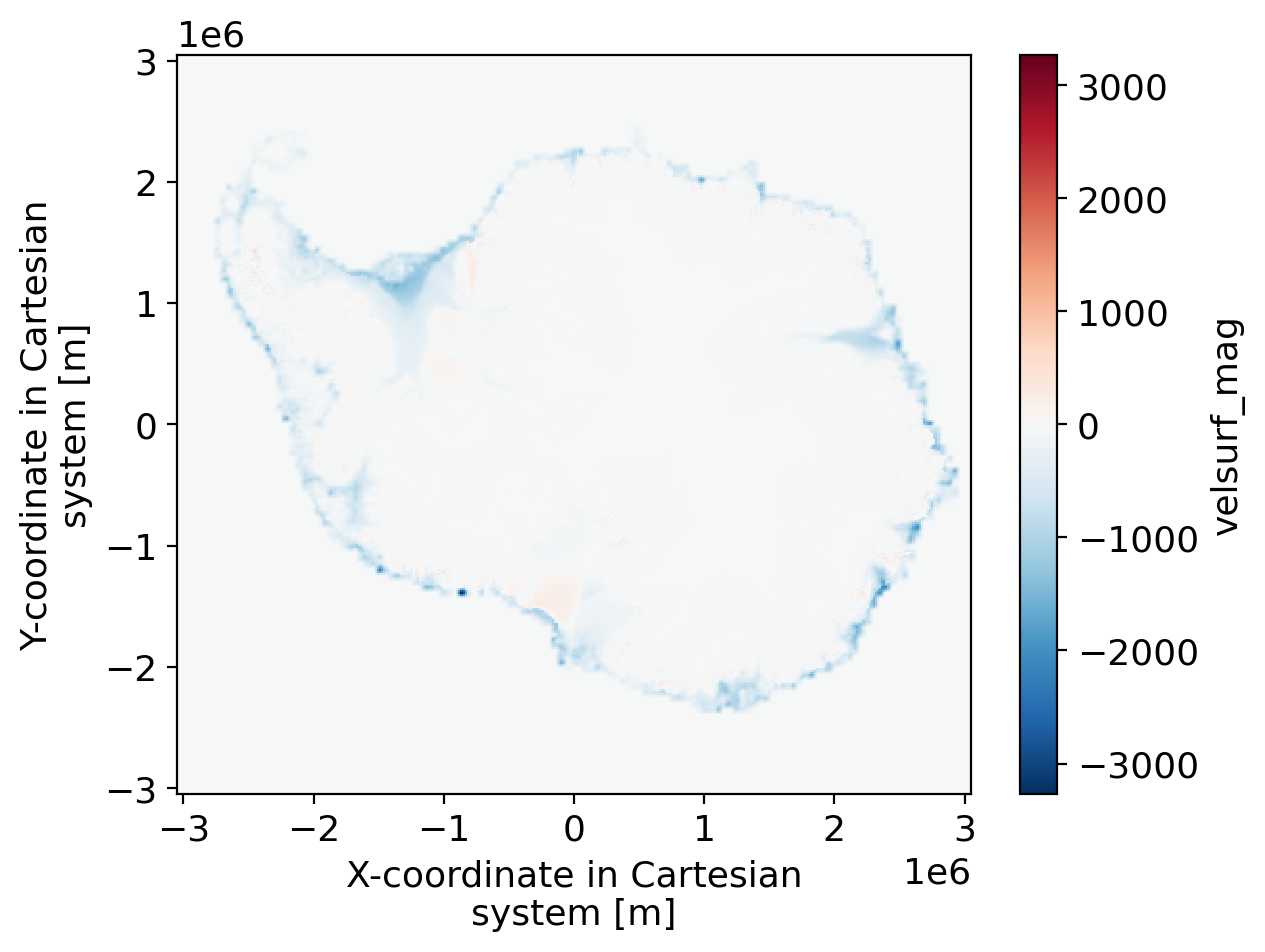

In [57]:
(y_true-y_test_pre_xr.velsurf_mag).mean(dim='time').plot()

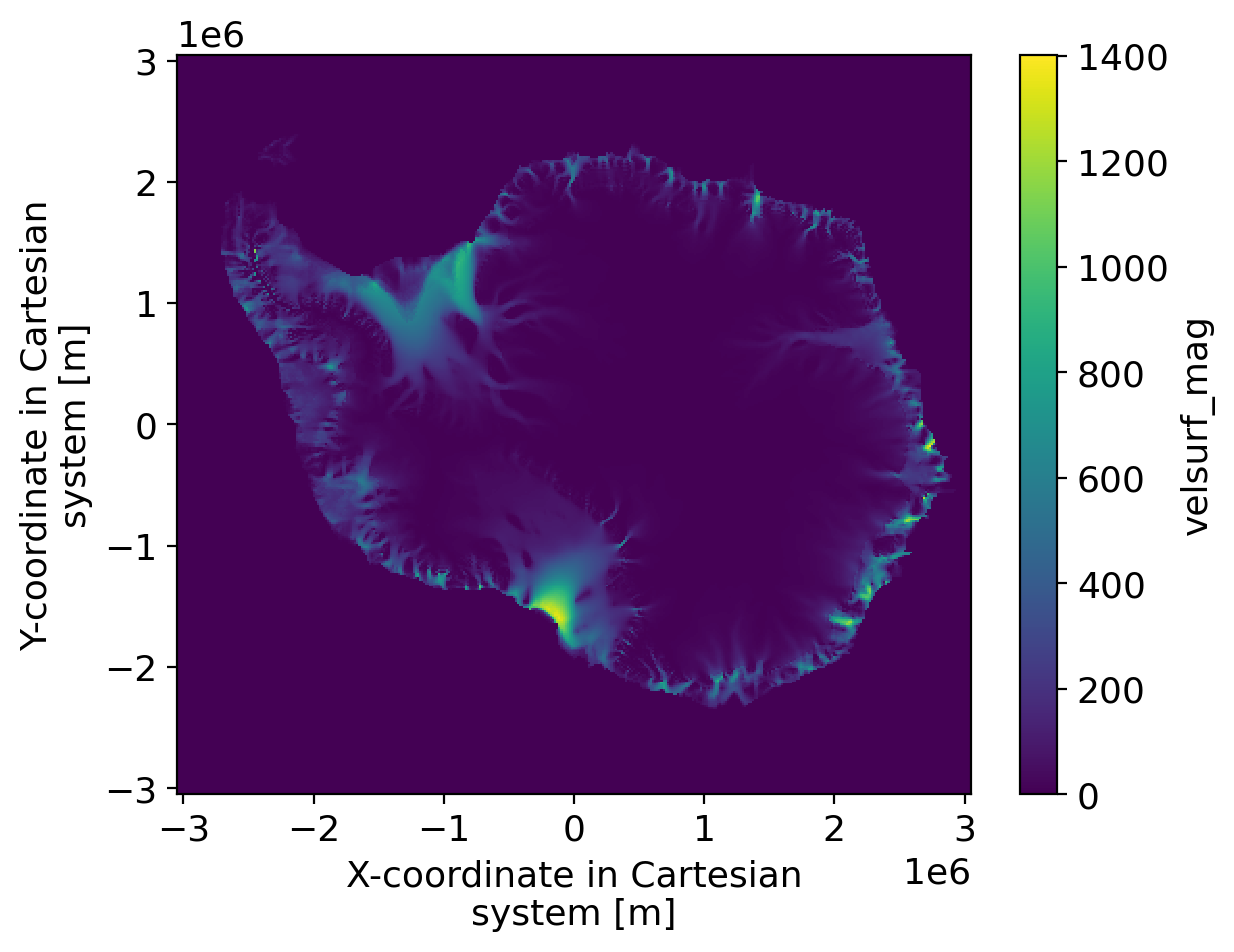

In [58]:
y_true.mean(dim='time').plot()

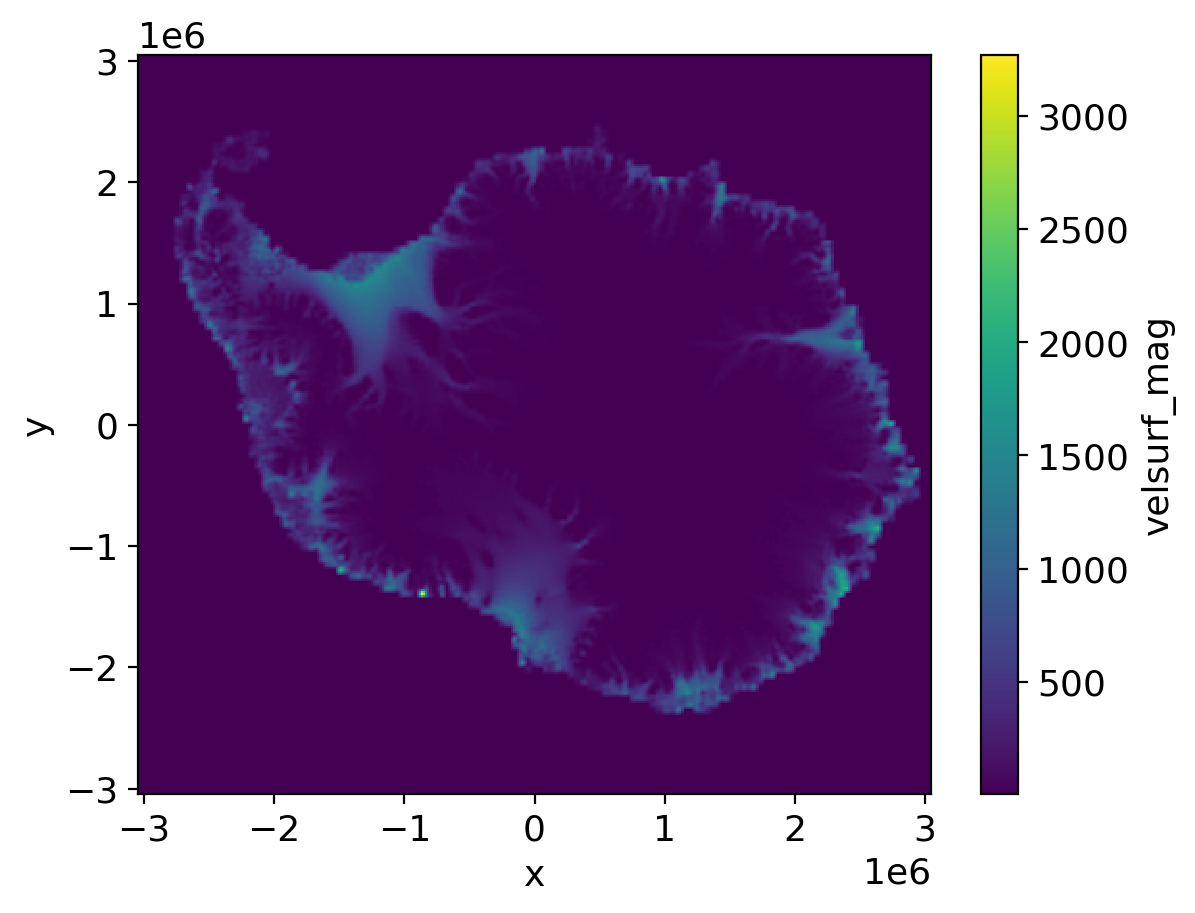

In [59]:
y_test_pre_xr.velsurf_mag.mean(dim='time').plot()